# Analyzing Milwaukee Police Call Data and Weather Data
### Grant Fass and Chris Hubbell

## Introduction
Across the world, there are many crimes commited every hour. One of the greatest challenges is reducing crime and maintaining safety for citizens. Part of preventing crime relies on the reporting of it by citizens. If nobody informs the police, the police are unable to act. This is why reporting crimes and incidents is so important, especially when people's lives are in danger. In Wisconsin, Milwaukee Police Department (MPD) releases data regarding all of their dispatch calls, which we have been able to get since 2016. This allows for analyzing trends of crime reporting over time as well as as it relates to other factors. In 2010, Milwaukee installed a new system for detecting gun shots called ShotSpotter, which was expanded into more neighborhoods in 2014. This system is capable of detecting when a shot is fired and where it was to a high degree of accuracy. The data consists of both ShotSpotter calls as well as Shots Fired calls. The key difference is that Shots Fired are calls from people and ShotSpotter are automatic.

## Research Questions:
- Is there a significant difference between the distribution of shots spotted over time and calls for shots fired?
- Is there a significant difference in the number of calls that were unable to be located for shots fired calls compared to shots spotted?
- Does the number of shots spotted and fired correlate with certain dates including holidays and events?
- Does the number of calls correlate with certain weather conditions?
- Is it possible to predict number of calls based on location and district?
- Is it possible to predict the nature of a call based on its location and district?

## Hypotheses:
- There are significantly more shots spotted than calls about shots fired.
- Significantly more shots fired calls are unable to be located than shots spotted.
- There will be significantly more shots spotted calls on July 4th, Dec. 31st, and Jan 1st than normal days.
- There will be significantly less shots fired calls on holidays than normal days.
- There are significantly more calls on days with clear weather than inclement weather.
- There are significantly more calls on days around 75 degrees than there are on days around 95 or 55 degrees.
- The number of calls will be able to be predicted based on location and district.
- The type of call will be unable to be predicted based on location and district.

# Imports
These are the libraries that will be relvant for working with the dataset.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import Image
sns.set()

# Loading the Data
This section is used to load the data and make sure that all of the features have been formatted using the correct types. This data is ready for use since it has already been cleaned in another notebook. The MPDDataCleaning notebook was used to clean the MPD (Milwaukee Police Department) dataset. The WeatherDataCleaning notebook was used to clean the weather dataset. These two datasets were then combined in the DatasetCombining notebook.

In [125]:
df = pd.read_csv('merged_data.csv')

C:\Users\fassg\AppData\Local\Temp/ipykernel_141216/188644660.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_data.csv')


,district,nature,status,call_id,datetime,traffic_crime,weapon_crime,isCorner,houseNumber,primaryStreetName,...,humidity,visibilityKm,pressureMB,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex
0,NaN,FOLLOW UP,Assignment Completed,163120850,2016-11-07 09:33:52,False,False,False,2920.0,N 4TH,...,64,10,1026,1,14,7,14,18,14,4
1,NaN,PROPERTY DAMAGE,Advised/Referral,163120774,2016-11-07 09:33:55,False,False,False,5929.0,W BLUE MOUND,...,64,10,1026,1,14,7,14,18,14,4
2,NaN,VACANT HOUSE CHK,Assignment Completed,163120851,2016-11-07 09:34:58,False,False,False,3425.0,N 93RD,...,64,10,1026,1,14,7,14,18,14,4
3,NaN,FOLLOW UP,Assignment Completed,163120853,2016-11-07 09:36:20,False,False,False,245.0,W LINCOLN,...,64,10,1026,1,14,7,14,18,14,4
4,NaN,TRAFFIC STOP,Advised,163120857,2016-11-07 09:38:10,True,False,False,765.0,N 25TH,...,64,10,1026,1,14,7,14,18,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027690,3,TRAFFIC LASER,Service in Progress,220101027,2022-01-10 15:28:31,False,False,False,2700.0,W VLIET,...,65,10,1033,10,-13,-18,-21,25,-21,2
4027691,6,TRAFFIC STOP,Advised,220101028,2022-01-10 15:29:07,True,False,False,3136.0,S 43RD,...,65,10,1033,10,-13,-18,-21,25,-21,2
4027692,1,BATTERY,To be Filed,220101031,2022-01-10 15:32:26,False,False,False,522.0,N WATER,...,68,10,1033,10,-13,-17,-21,23,-21,2
4027693,4,ACC PI,Service in Progress,220101034,2022-01-10 15:34:19,False,False,False,5100.0,N LOVERS LANE,...,68,10,1033,10,-13,-17,-21,23,-21,2


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027695 entries, 0 to 4027694
Data columns (total 30 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   district               object 
 1   nature                 object 
 2   status                 object 
 3   call_id                int64  
 4   datetime               object 
 5   traffic_crime          bool   
 6   weapon_crime           bool   
 7   isCorner               bool   
 8   houseNumber            float64
 9   primaryStreetName      object 
 10  primaryStreetSuffix    object 
 11  secondaryStreetName    object 
 12  secondaryStreetSuffix  object 
 13  loc_id                 int64  
 14  isdaytime              bool   
 15  tempC                  int64  
 16  windspeedKmph          int64  
 17  winddirdegree          int64  
 18  weatherDesc            object 
 19  precipMM               float64
 20  humidity               int64  
 21  visibilityKm           int64  
 22  pressureMB        

## Revising Feature Types
Calling the [`.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) command shows that there are a number of features that are improperly formatted. The district, nature, status, primaryStreetName, primaryStreetSuffix, secondaryStreetName, secondaryStreetSuffix, and weatherDesc all need to become categorical features. The datetime feature needs to be changed to datetime.

In [127]:
df['district'] = df['district'].astype('category')
df['nature'] = df['nature'].astype('category')
df['status'] = df['status'].astype('category')
df['primaryStreetName'] = df['primaryStreetName'].astype('category')
df['primaryStreetSuffix'] = df['primaryStreetSuffix'].astype('category')
df['secondaryStreetName'] = df['secondaryStreetName'].astype('category')
df['secondaryStreetSuffix'] = df['secondaryStreetSuffix'].astype('category')
df['weatherDesc'] = df['weatherDesc'].astype('category')
df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)

## Examining The Loaded Data
The data should now be in the proper types. This will be examined using the [`.head()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html), [`.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html), and [`.describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) methods.

In [132]:
df.head(5).T

,0,1,2,3,4
district,NaN,NaN,NaN,NaN,NaN
nature,FOLLOW UP,PROPERTY DAMAGE,VACANT HOUSE CHK,FOLLOW UP,TRAFFIC STOP
status,Assignment Completed,Advised/Referral,Assignment Completed,Assignment Completed,Advised
call_id,163120850,163120774,163120851,163120853,163120857
datetime,2016-11-07 09:33:52,2016-11-07 09:33:55,2016-11-07 09:34:58,2016-11-07 09:36:20,2016-11-07 09:38:10
traffic_crime,False,False,False,False,True
weapon_crime,False,False,False,False,False
isCorner,False,False,False,False,False
houseNumber,2920.0,5929.0,3425.0,245.0,765.0
primaryStreetName,N 4TH,W BLUE MOUND,N 93RD,W LINCOLN,N 25TH


In [129]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027695 entries, 0 to 4027694
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   district               3937463 non-null  category      
 1   nature                 4027695 non-null  category      
 2   status                 4027695 non-null  category      
 3   call_id                4027695 non-null  int64         
 4   datetime               4027695 non-null  datetime64[ns]
 5   traffic_crime          4027695 non-null  bool          
 6   weapon_crime           4027695 non-null  bool          
 7   isCorner               4027695 non-null  bool          
 8   houseNumber            3426083 non-null  float64       
 9   primaryStreetName      4016778 non-null  category      
 10  primaryStreetSuffix    3844881 non-null  category      
 11  secondaryStreetName    549421 non-null   category      
 12  secondaryStreetSuffix  53185

In [130]:
df.describe()

,call_id,houseNumber,loc_id,tempC,windspeedKmph,winddirdegree,precipMM,humidity,visibilityKm,pressureMB,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex
count,4.027695e+06,3.426083e+06,4027695.0,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06
mean,1.891808e+08,3.367593e+03,1.0,9.332960e+00,1.396831e+01,1.978097e+02,8.068526e-02,7.252384e+01,9.280653e+00,1.016711e+03,4.627480e+01,9.741805e+00,4.295812e+00,7.040703e+00,2.030895e+01,7.329460e+00,2.161411e+00
std,1.459309e+07,2.415387e+03,0.0,1.099667e+01,6.506821e+00,9.301290e+01,3.459743e-01,1.560838e+01,1.861185e+00,7.728984e+00,3.620323e+01,1.150243e+01,1.050146e+01,1.314242e+01,9.506874e+00,1.356433e+01,1.869588e+00
min,1.630815e+08,1.000000e+00,1.0,-3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,0.000000e+00,9.860000e+02,0.000000e+00,-3.000000e+01,-3.400000e+01,-4.400000e+01,0.000000e+00,-4.400000e+01,1.000000e+00
25%,1.732129e+08,1.614000e+03,1.0,1.000000e+00,9.000000e+00,1.260000e+02,0.000000e+00,6.100000e+01,1.000000e+01,1.012000e+03,1.100000e+01,1.000000e+00,-4.000000e+00,-3.000000e+00,1.300000e+01,-3.000000e+00,1.000000e+00
50%,1.906707e+08,2.920000e+03,1.0,9.000000e+00,1.300000e+01,2.140000e+02,0.000000e+00,7.400000e+01,1.000000e+01,1.016000e+03,3.900000e+01,9.000000e+00,4.000000e+00,6.000000e+00,1.900000e+01,6.000000e+00,1.000000e+00
75%,2.016115e+08,4.600000e+03,1.0,1.900000e+01,1.800000e+01,2.760000e+02,0.000000e+00,8.500000e+01,1.000000e+01,1.021000e+03,8.300000e+01,1.900000e+01,1.400000e+01,1.900000e+01,2.600000e+01,1.900000e+01,3.000000e+00
max,2.201010e+08,6.460500e+05,1.0,3.500000e+01,4.700000e+01,3.600000e+02,1.630000e+01,1.000000e+02,1.000000e+01,1.048000e+03,1.000000e+02,4.100000e+01,2.700000e+01,3.500000e+01,7.100000e+01,4.100000e+01,9.000000e+00


# TODO: Explain



# TODO GRAPHS
- Date vs number/calls line graph
- Box plot of district/num calls
- heatmap call type/status? Is this too big?
- district/nature
- time/nature
- time/status
- calls that are 'in service' and 'resolved' , are they related? compare by time? would ID's match?

// TODO: describe the features in m.  
// TODO: update description of weather dataset and where it came from  
// TODO: note down research questions and hypotheses at the top of the notebook  

# Graphs

Text(0.5, 1.0, 'All Selected Call Types Over Time')

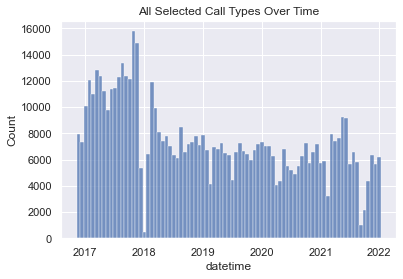

In [77]:
ax = sns.histplot(data=merged_data, x='datetime')
ax.set_title('All Selected Call Types Over Time')

In [113]:
# This cell pulls out the week and day as a seperate feture to use for graphing datetime versus nature.
stacked_data = merged_data[['datetime', 'nature']].copy(deep=True)
stacked_data['week'] = stacked_data['datetime'].map(lambda x: x.week)
stacked_data['day'] = stacked_data['datetime'].map(lambda x: x.day)
stacked_data

,datetime,nature,week,day
0,2016-11-07 09:38:10,TRAFFIC STOP,45,7
1,2016-11-07 09:42:36,TRAFFIC STOP,45,7
2,2016-11-07 10:04:07,SUBJ WITH WEAPON,45,7
3,2016-11-07 10:12:37,TRAFFIC STOP,45,7
4,2016-11-07 10:21:43,TRAFFIC STOP,45,7
...,...,...,...,...
620447,2022-01-10 15:20:44,TRAFFIC STOP,2,10
620448,2022-01-10 15:25:10,TRAFFIC STOP,2,10
620449,2022-01-10 15:26:54,SHOTS FIRED,2,10
620450,2022-01-10 15:28:00,TRAFFIC STOP,2,10


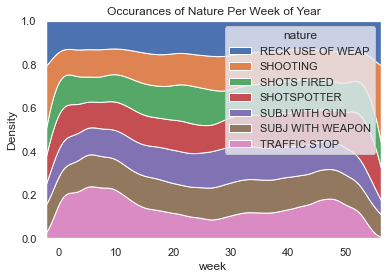

In [115]:
sns.kdeplot(x=stacked_data["week"], hue=stacked_data["nature"], common_norm=False, multiple="fill", alpha=1)
plt.title("Occurances of Nature Per Week of Year")
plt.show()

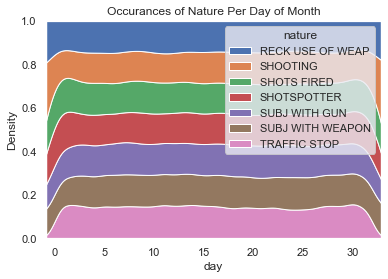

In [117]:
sns.kdeplot(x=stacked_data["day"], hue=stacked_data["nature"], common_norm=False, multiple="fill", alpha=1)
plt.title("Occurances of Nature Per Day of Month")
plt.show()

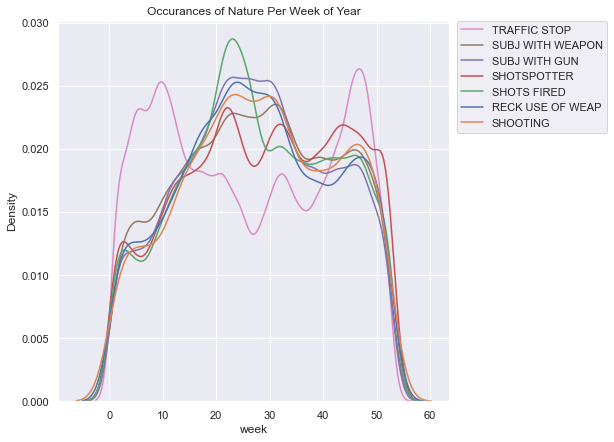

In [112]:
# https://www.statology.org/seaborn-legend-outside/ for moving the legend outside
# https://stackoverflow.com/a/60679315 for plotting multiple categories (fix legend not showing)
uses = stacked_data['nature'].unique()
plt.figure(figsize=(7,7))
ax = plt.axes()
for use in uses:
    sns.kdeplot(x=stacked_data["week"], hue=stacked_data[stacked_data['nature']==use]["nature"], 
    ax=ax, common_norm=False, multiple="layer", alpha=1, label=use)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Occurances of Nature Per Week of Year")
plt.show()

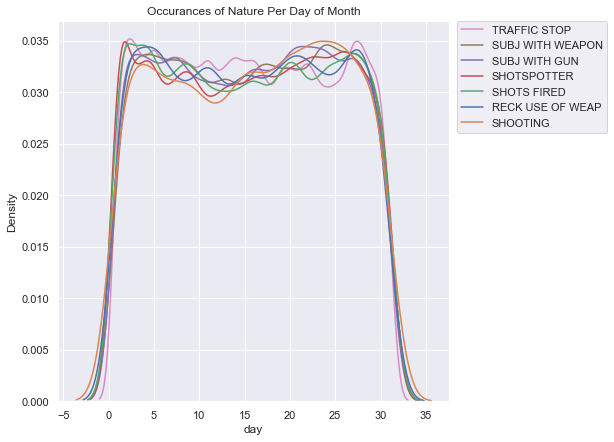

In [121]:
# https://www.statology.org/seaborn-legend-outside/ for moving the legend outside
# https://stackoverflow.com/a/60679315 for plotting multiple categories (fix legend not showing)
uses = stacked_data['nature'].unique()
plt.figure(figsize=(7,7))
ax = plt.axes()
for use in uses:
    sns.kdeplot(x=stacked_data["day"], hue=stacked_data[stacked_data['nature']==use]["nature"], 
    ax=ax, common_norm=False, multiple="layer", alpha=1, label=use)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Occurances of Nature Per Day of Month")
plt.show()

In [ ]:
#TODO: undo the parse down and add a is_gun_violence set